# Obtaining clonal snaphots, movies and T1 rate

Note, we use slightly different parameters to before (see Supplemental Theory). For fitting a lower ratio of division time to mechanical relaxation time was used to allow feasibility of parameter optimisation given that simulations are very computationally intensive. Here, we use a higher ratio of division time to mechanical relaxation as time-scales associated mechanical relaxation (adhesion, contractility, etc) are fast compared to division. We choose a suitably high value, such that the level of clonal fragmentation is qualitatively similar to in experiments. Lower ratios result in even more significant levels of clonal fragmentation than are seen experimentally.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from numba import jit
import sys
import pickle

sys.path.append("../../simulator/")
sys.path.append("../../fitting/")


from tissue import *
import tissplot as tplt
import matplotlib.path as mplPath
import analysis
import datasets as ds
import sim_model as sm

%matplotlib inline

def addPBC(points, L, rinc = None): #rinc is inclusion radius for PBCs
    if rinc == None:
        rinc = L
    vx = L*np.array((1,0), dtype = np.float64)
    vy = L*np.array((0,1), dtype = np.float64)
    left  = points[:,0] < rinc
    right = points[:,0] > L - rinc
    up    = points[:,1] > L - rinc
    down  = points[:,1] < rinc
    points = np.vstack([points, 
                        points[left ].copy() + vx, 
                        points[right].copy() - vx, 
                        points[up   ].copy() - vy, 
                        points[down ].copy() + vy, 
                        points[left  & down].copy() + vx + vy, 
                        points[right & up  ].copy() - vx - vy, 
                        points[left  & up  ].copy() + vx - vy, 
                        points[right & down].copy() - vx + vy])
    return points


def load_object(filename):
    with open(filename, 'rb') as outp:  # Overwrites any existing file.
        return pickle.load(outp)
    
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
        


In [2]:
# Load the experimental data

exp_data = load_object('../../experiment/ablation.pkl')

av_edu_pc = exp_data['expDivrate']/exp_data['ctrDivrate']
se_edu_pc = exp_data['expSEDivrate']/exp_data['ctrDivrate']
ct_edu_pc = 1.0

av_bas = np.array(exp_data['expDensity'])
sd_bas = np.array(exp_data['expSEDensity'])

av_bas_exp = np.array(exp_data['expBasalsize'])
se_bas_exp = np.array(exp_data['expSEBasalsize'])

av_tot_exp = np.array(exp_data['expTotalsize'])
se_tot_exp = np.array(exp_data['expSETotalsize'])

tdr = exp_data['expTimeDivrate']
tds = exp_data['expTimeDensity']
te  = exp_data['expTimeClonesize']

tc  = exp_data['ctrTimeClonesize']

cpdf = np.zeros((len(tc),3,226))
dspers = np.array([1,11])


av_bas_ctr  = np.array(exp_data['ctrBasalsize'])
av_tot_ctr  = np.array(exp_data['ctrTotalsize'])
se_bas_ctr  = np.array(exp_data['ctrSEBasalsize'])
se_tot_ctr  = np.array(exp_data['ctrSETotalsize'])
cpdf[:,:,:np.shape(exp_data['ctrpdf'])[2]] += exp_data['ctrpdf']     #exp_data['ctrpdf']
cs_bas_ctr  = exp_data['ctrFullBasalsize']
cs_tot_ctr  = exp_data['ctrFullTotalsize'] 
av_ctr_pers = exp_data['ctrPersistence']
se_ctr_pers = exp_data['ctrSEPersistence']
    


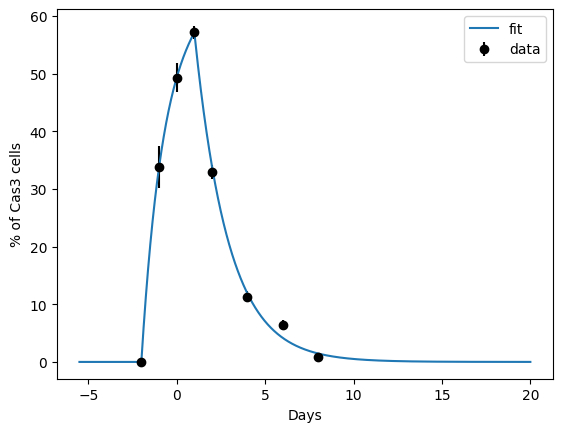

In [3]:
# Specify the death profile:

#Numbers otained by fits to data
b1 = 3.2553e-2
b2 = 8.7969e-1
bx = 0.5240

def death(t, b1, b2, bx, tscale = 1, tshift = 0, tmin = - 3):
    t = t/tscale + tshift
    if type(t) == int or type(t) == float:
        t = np.array([t])
    y = np.zeros(len(np.array(t)))
    y[t >= 0] = np.exp(-bx*t[t >= 0])
    y[t  < 0] = np.exp(b1*(t[t < 0] - tmin))*(1 - np.exp(-b2*(t[t < 0] - tmin)))/np.exp(-tmin*b1)/(1 - np.exp(tmin*b2))
    y[t < tmin] = 0.0
    return y

x = np.linspace(-5.5, 20, 22*101)

plt.figure()
plt.errorbar(exp_data['timeCas3'], exp_data['expCas3'], exp_data['expSECas3'], fmt = 'ko', label = 'data')
plt.plot(x, death(x - 1, b1, b2, bx)*np.max(exp_data['expCas3']), label = 'fit')
plt.ylabel('% of Cas3 cells')
plt.xlabel('Days')
plt.legend()
#plt.xlim([])
plt.savefig('deathprofile.png', dpi = 300)
plt.show()

In [4]:
# Run simulations of ablation

L = 20
tsteps = 5000

tau   = 2500
shed = 0.4*tau
rho =  0.9
r = 0.3
Ahigh = 1.25
tadiv = 150
ncells = L**2
tscale  = 200
tshift  = -5


for s in range(0,20):
    np.random.seed(s)
    t0 = sm.SD_mech_switch(ncells, L, tau, r, rho, shed = shed, tadiv = tadiv, 
                        switch_profile = 'binary', hilln = 10, Ahigh = Ahigh)
    
    results = t0.sim(tsteps = 1000, dt = 0.01, Dr = 0.0, v0 = 0.0, mu = 1.0,  
                    kA = 1.0, kP = 1.0, A0 = 1.0, p0 = 3.5, plot = False)
    results1 = t0.simFull(tsteps = 1500, dt = 0.01, Dr = 0.0, v0 = 0.0, mu = 1.0, kA = 1.0, kP = 1.0, A0 = 1.0, p0 = 3.5, plot = False, skip = 100)
    t1 = t0.copy()
    t1.reset()
    resultsC = t1.simFull(tsteps = 5000, dt = 0.01, Dr = 0.0, v0 = 0.0, mu = 1.0,  
                    kA = 1.0, kP = 1.0, A0 = 1.0, p0 = 3.5, plot = False, save_shape = True,
                    skip = 10, verbose = False)

    killprofile = 0.9/tscale*death(np.arange(tsteps), b1, b2, bx, tscale, tshift - 1)
    t2 = t1.copy()
    t2.reset()
    results = t2.simFull(tsteps = tsteps, dt = 0.01, Dr = 0.0, v0 = 0.0, mu = 1.0,  
                    kA = 1.0, kP = 1.0, A0 = 1.0, p0 = 3.5, plot = False, skip = 10, 
                        killprofile = killprofile, save_shape = True)
    results['t2']  = t2
    resultsC['t1'] = t1 
    
    ds.save_object({'results': results, 'resultsC': resultsC}, 'ablation_long_sim_' + str(s) + '.pkl')
    
assert(0)

Starting sim with 400 cells at Tue Jun 25 00:17:29 2024
Ending sim with 400 cells at Tue Jun 25 00:18:19 2024
Starting sim with 400 cells at Tue Jun 25 00:18:19 2024
Ending sim with 404 cells at Tue Jun 25 00:19:25 2024
Resetting time and division times
Starting sim with 404 cells at Tue Jun 25 00:19:25 2024
Ending sim with 403 cells at Tue Jun 25 00:23:49 2024
Resetting time and division times
Using specified cell death profile
Starting sim with 403 cells at Tue Jun 25 00:23:49 2024
Ending sim with 385 cells at Tue Jun 25 00:26:59 2024
Starting sim with 400 cells at Tue Jun 25 00:27:00 2024
Ending sim with 400 cells at Tue Jun 25 00:27:40 2024
Starting sim with 400 cells at Tue Jun 25 00:27:40 2024
Ending sim with 400 cells at Tue Jun 25 00:28:43 2024
Resetting time and division times
Starting sim with 400 cells at Tue Jun 25 00:28:43 2024
Ending sim with 408 cells at Tue Jun 25 00:32:58 2024
Resetting time and division times
Using specified cell death profile
Starting sim with 408 ce

AssertionError: 

In [108]:
#TPA results
#Example simulation of TPA-like conditions with accelerated division rate relative to control

L = 20
tsteps = 4600

tau   = 1000
shed = 0.4*tau
rho =  0.9
r = 0.3
Ahigh = 2.0
tadiv = 150
ncells = L**2
tscale  = 400
tshift  = -5


for s in range(0,20):
    np.random.seed(s)
    t0 = sm.SD_mech_switch(ncells, L, tau, r, rho, shed = shed, tadiv = tadiv, 
                        switch_profile = 'binary', hilln = 10, Ahigh = Ahigh, mu = 2*277.77)
    results = t0.sim(tsteps = 1000, dt = 0.01, Dr = 0.0, v0 = 0.0, mu = 1.0,  
                    kA = 1.0, kP = 1.0, A0 = 1.0, p0 = 3.5, plot = False, skip = 1000)
    results1 = t0.simFull(tsteps = 1500, dt = 0.01, Dr = 0.0, v0 = 0.0, mu = 1.0, kA = 1.0, kP = 1.0, A0 = 1.0, p0 = 3.5, plot = False, skip = 1000)
    t1 = t0.copy()
    t1.reset()
    resultsC = t1.simFull(tsteps = 8000, dt = 0.01, Dr = 0.0, v0 = 0.0, mu = 1.0,  
                    kA = 1.0, kP = 1.0, A0 = 1.0, p0 = 3.5, plot = False, save_shape = True,
                    skip = 20, verbose = False)

    resultsC['tiss'] = t1
    
    ds.save_object({'resultsC': resultsC}, 'TPA_long_sim_' + str(s) + '.pkl')
    
assert(0)

Starting sim with 400 cells at Fri Apr 19 12:11:47 2024
Ending sim with 400 cells at Fri Apr 19 12:12:39 2024
Starting sim with 400 cells at Fri Apr 19 12:12:39 2024
Ending sim with 399 cells at Fri Apr 19 12:13:48 2024
Resetting time and division times
Starting sim with 399 cells at Fri Apr 19 12:13:48 2024
Ending sim with 396 cells at Fri Apr 19 12:20:26 2024
Starting sim with 400 cells at Fri Apr 19 12:20:27 2024
Ending sim with 400 cells at Fri Apr 19 12:21:14 2024
Starting sim with 400 cells at Fri Apr 19 12:21:14 2024
Ending sim with 415 cells at Fri Apr 19 12:22:18 2024
Resetting time and division times
Starting sim with 415 cells at Fri Apr 19 12:22:18 2024
Ending sim with 393 cells at Fri Apr 19 12:28:18 2024
Starting sim with 400 cells at Fri Apr 19 12:28:18 2024
Ending sim with 400 cells at Fri Apr 19 12:29:06 2024
Starting sim with 400 cells at Fri Apr 19 12:29:06 2024
Ending sim with 410 cells at Fri Apr 19 12:30:10 2024
Resetting time and division times
Starting sim with 

AssertionError: 

In [4]:
import shape_analysis as sa


numt1_ctr = np.zeros((20, 500))
numt1_exp = np.zeros((20, 500))
numt1_tpa = np.zeros((20, 400))


ncells_ctr = np.zeros((20, 5001))
ncells_exp = np.zeros((20, 5001))
#ncells_tpa = np.zeros((20, 8001))



for s in range(20):
    print('Seed:', s)
    dd = ds.load_object('ablation_long_sim_' + str(s) + '.pkl')
    #dt = ds.load_object('TPA_long_sim_' + str(s) + '.pkl')
    
    results = dd['results']
    resultsC = dd['resultsC']
    #resultsT = dt['resultsC']
    
    ncells_ctr[s,:] = np.sum(resultsC['ncells'],1)
    ncells_exp[s,:] = np.sum(results['ncells'],1)
    #ncells_tpa[s,:] = np.sum(resultsT['ncells'],1)
    
    cellids = resultsC['cellid']
    jlengths_ctr = resultsC['shapes']['jlengths']
    perims_ctr = resultsC['shapes']['perims']

    t1s_ctr  = sa.T1s(jlengths_ctr, cellids)
    nt1s_ctr = {tx: len(t1s_ctr[tx]) for tx in t1s_ctr.keys()}

    numt1_ctr[s, np.array(list(t1s_ctr.keys()))] += np.array(list(nt1s_ctr.values()))


    cellids = results['cellid']
    jlengths_exp = results['shapes']['jlengths']
    perims_exp = results['shapes']['perims']


    t1s_exp  = sa.T1s(jlengths_exp, cellids)
    nt1s_exp = {tx: len(t1s_exp[tx]) for tx in t1s_exp.keys()}
    numt1_exp[s,np.array(list(t1s_exp.keys()))] += np.array(list(nt1s_exp.values()))
    
    continue
    cellids = resultsT['cellid']
    jlengths_tpa = resultsT['shapes']['jlengths']
    perims_tpa = resultsT['shapes']['perims']
    
    t1s_tpa  = sa.T1s(jlengths_tpa, cellids)
    nt1s_tpa = {tx: len(t1s_tpa[tx]) for tx in t1s_tpa.keys()}
    numt1_tpa[s,np.array(list(t1s_tpa.keys()))] += np.array(list(nt1s_tpa.values()))


Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Seed: 10
Seed: 11
Seed: 12
Seed: 13
Seed: 14
Seed: 15
Seed: 16
Seed: 17
Seed: 18
Seed: 19


In [12]:
from matplotlib import rcParams

# Set global font properties
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'bold'
rcParams["font.sans-serif"] = ["Calibri"]

# Set global font size for all axes
rcParams['axes.labelsize'] = 10
rcParams['axes.labelweight'] = 'bold'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10
rcParams['font.size'] = 10  # General font size
rcParams['text.usetex'] = False
rcParams['svg.fonttype'] = 'none'
rcParams['lines.markersize']  = 3
rcParams['lines.linewidth']  = 1.5


findfont: Generic family 'sans-serif' not found because none of the following families were found: Calibri
findfont: Generic family 'sans-serif' not found because none of the following families were found: Calibri
findfont: Generic family 'sans-serif' not found because none of the following families were found: Calibri
findfont: Generic family 'sans-serif' not found because none of the following families were found: Calibri
findfont: Generic family 'sans-serif' not found because none of the following families were found: Calibri
findfont: Generic family 'sans-serif' not found because none of the following families were found: Calibri
findfont: Generic family 'sans-serif' not found because none of the following families were found: Calibri
findfont: Generic family 'sans-serif' not found because none of the following families were found: Calibri
findfont: Generic family 'sans-serif' not found because none of the following families were found: Calibri
findfont: Generic family 'sans-serif'

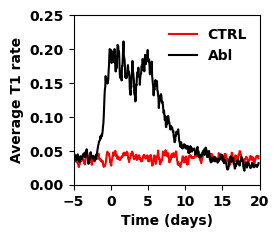

In [22]:
from importlib import reload
reload(plt)
sl = slice(2,-2)

dx = 5
tscale = 200
tscale2 = 400
tshift = -5
plt.figure(figsize = (2.4,2.2))
plt.plot(np.arange(0,5000,10)[sl]/tscale + tshift,  (np.convolve(np.mean(numt1_ctr,0), np.ones(dx)/dx, mode='same')/(10/tscale)/np.mean(ncells_ctr,0)[:-1:10])[sl], 'r', label = 'CTRL')
plt.plot(np.arange(0,5000,10)[sl]/tscale + tshift,  (np.convolve(np.mean(numt1_exp,0), np.ones(dx)/dx, mode='same')/(10/tscale)/np.mean(ncells_exp,0)[:-1:10])[sl], 'k', label = 'Abl')
#plt.plot(np.arange(0,5000,20)/tscale2 + tshift,  np.convolve(np.mean(numt1_tpa,0), np.ones(dx)/dx, mode='same')/(20/tscale2)/np.mean(ncells_tpa,0)[:-1:20], 'b', label = 'TPA', linewidth = 2.5)
plt.xticks()
plt.yticks()
plt.xlabel('Time (days)')
plt.ylabel('Average T1 rate')
plt.legend(frameon=False)
plt.xlim([-5,20])
plt.ylim([0,0.25])
plt.xticks(np.arange(-5,21,5))
plt.savefig('Fig3E_T1s.pdf', dpi = 400, bbox_inches = 'tight')
plt.show()

# Snapshots and movies

The below code produces the snapshots and movies used in the paper

In [ ]:
#Homeostatic simulation


L = 20
tsteps = 1000


tau   = 2500
shed = 0.4*tau

rho =  0.9
r = 0.3

Ahigh = 1.25
tadiv = 150

ncells = L**2


t0 = sm.SD_mech_switch(ncells, L, tau, r, rho, shed = shed, tadiv = tadiv, 
                       switch_profile = 'binary', hilln = 10, Ahigh = Ahigh)

results = t0.sim(tsteps = 1000, dt = 0.01, Dr = 0.0, v0 = 0.0, mu = 1.0,  
                 kA = 1.0, kP = 1.0, A0 = 1.0, p0 = 3.5, plot = False)

points = t0.cellpoints % L

results1 = t0.simFull(tsteps = 1500, dt = 0.01, Dr = 0.0, v0 = 0.0, mu = 1.0, kA = 1.0, kP = 1.0, A0 = 1.0, p0 = 3.5, plot = False, skip = 100)

points = t0.cellpoints % L

tplt.plotBCD(results1)

t1 = t0.copy()
t1.reset()

resultsC = t1.simFull(tsteps = 4000, dt = 0.01, Dr = 0.0, v0 = 0.0, mu = 1.0,  
                 kA = 1.0, kP = 1.0, A0 = 1.0, p0 = 3.5, plot = False, save_shape = True,
                 skip = 10, verbose = False)


tplt.plotBCD(resultsC)

drate = ds.simDivrate(t1, resultsC, tsteps = 4000, dx = 100)
plt.figure()
plt.plot(np.arange(4001), drate*2500/rho)
#plt.errorbar(tdr, av_edu_pc, se_edu_pc, fmt='ko')
plt.xlabel('Time (days)')
plt.ylabel('Division rate')
plt.show()

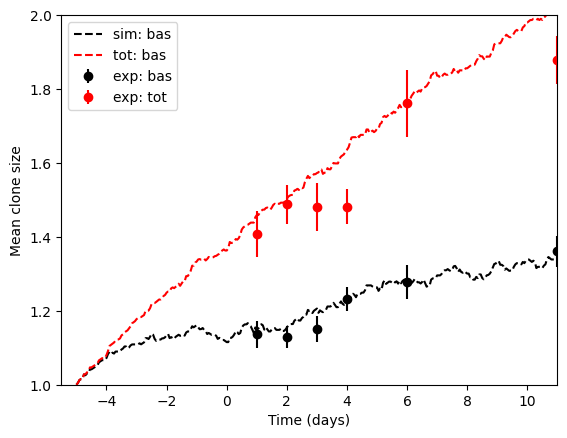

In [6]:
#Finding correct time re-scaling and shed rate

import clones


tscale  = 200
tshift  = -5


resultsC = t1.rerunsuprabasal(resultsC, 4000, 0.8*tau, skip = 10)

ca_ctr = clones.sanalysis(resultsC, popnames = ['D', 'S'], skip = 10)


plt.figure()
plt.errorbar(tc, av_bas_ctr, se_bas_ctr, fmt ='ko', label = 'exp: bas')
plt.plot(ca_ctr.tvals/tscale + tshift, ca_ctr.av_bas_cs, 'k--', label = 'sim: bas')
plt.errorbar(tc, av_tot_ctr, se_tot_ctr, fmt ='ro', label = 'exp: tot')
plt.plot(ca_ctr.tvals/tscale + tshift, ca_ctr.av_tot_cs, 'r--', label = 'tot: bas')
plt.xlim([-5.5,11])
plt.ylim([1,2])
plt.xlabel('Time (days)')
plt.ylabel('Mean clone size')
plt.legend()
plt.show()

Resetting time and division times
Using specified cell death profile
Starting sim with 407 cells at Mon Jun 24 15:56:21 2024
Ending sim with 373 cells at Mon Jun 24 15:59:17 2024


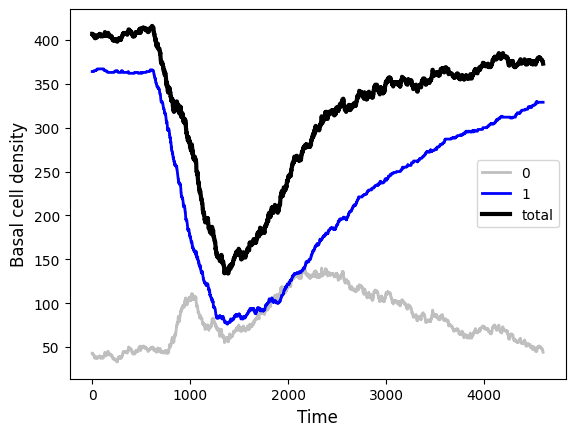

In [10]:
#Ablation simulation

tsteps = 4600
killprofile = 0.9/tscale*death(np.arange(tsteps), b1, b2, bx, tscale, tshift - 1)


t2 = t1.copy()
t2.reset()

results = t2.simFull(tsteps = tsteps, dt = 0.01, Dr = 0.0, v0 = 0.0, mu = 1.0,  
                 kA = 1.0, kP = 1.0, A0 = 1.0, p0 = 3.5, plot = False, skip = 10, 
                     killprofile = killprofile, save_shape = True)


tplt.plotBCD(results)
#plt.errorbar(tds, av_bas_exp, sd_bas_exp, fmt = 'ko')


In [12]:
# Save simulations for future use

resultsC['tiss'] = t1
save_object(resultsC, 'ctr_sim.pkl')

results['tiss'] = t2
save_object(results,  'exp_sim.pkl')

In [69]:
# Load simulation

resultsC = load_object('ctr_sim.pkl')
results  = load_object('exp_sim.pkl')
t1 = resultsC['tiss']
t2 = results['tiss']

Clone 410 r
Clone 559 g
Clone 893 y
Clone 206 b
Clone 410 r
Clone 559 g
Clone 893 y
Clone 206 b
Clone 410 r
Clone 559 g
Clone 893 y
Clone 206 b
Clone 410 r
Clone 559 g
Clone 893 y
Clone 206 b


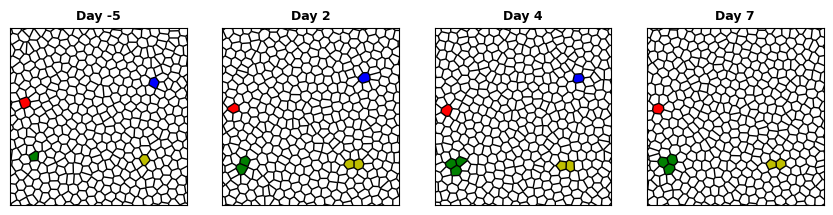

In [83]:
#Plot snapshot of control simulation
#as random seed may be different, you may need to select different clones to track

resultsC = load_object('ctr_sim.pkl')
t1 = resultsC['tiss']

rcParams['lines.linewidth']  = 1.0

tplt.clonal_snapshot(t1, resultsC, times = ds.exp2simSkippedTimes(np.array([-5,2,4,7]), 200, 5, skip = 10)*10, 
                     track = [410, 559, 893, 206], sample_mode = -10, cloneResults = None, 
                    skip = None, titles = ['Day -5', 'Day 2', 'Day 4', 'Day 7'], markpops = False, use_legend=False)
plt.savefig('Fig3F_ctr.pdf', dpi = 400, bbox_inches='tight')

In [63]:
# Make a movie of the control simulation
from importlib import reload
reload(tplt)

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

tiss = resultsC['tiss']
positions = resultsC['cellpos']
ancs = resultsC['anc']
ancs = {**ancs[0], **ancs[1]}

cellid = resultsC['cellid']
ncells = resultsC['ncells']

track = [410, 559, 893, 206]

animation = tplt.clone_movies(positions, ancs, cellid, ncells = ncells, track = track, 
                         nsteps = 400, savename = 'sim_ctr.mp4', fps = 10, 
                         saveskip = 10, diebytime = analysis.die_by_time(tiss, results, skip = 10, showfor = 100), 
                         delambytime = analysis.delam_by_time(tiss, resultsC, skip = 10, showfor = 100), L = 20,
                         tscale = 200, tshift = -5, skip = 1); 

4


Moviepy - Building video sim_ctr.mp4.
Moviepy - Writing video sim_ctr.mp4



Moviepy - Done !
Moviepy - video ready sim_ctr.mp4


Clone 1069 r
Clone 1266 g
Clone 3340 y
Clone 893 b
Clone 1069 r
Clone 1266 g
Clone 3340 y
Clone 893 b
Clone 1069 r
Clone 1266 g
Clone 3340 y
Clone 893 b
Clone 1069 r
Clone 1266 g
Clone 3340 y
Clone 893 b


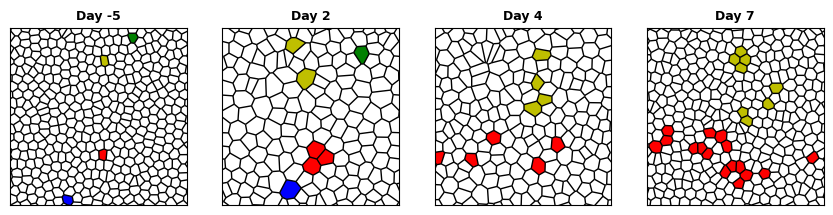

In [82]:
#Plot snapshot of ablation simulation
results =  load_object('ablation_long_sim_2.pkl')
results = results['results']
t2 = results['t2']

#1069, 399, 3141, 3340, 1266, 1736

# 1069, 1266, 3340, 893, 2854

tplt.clonal_snapshot(t2, results, times = ds.exp2simSkippedTimes(np.array([-5,2,4,7]), 200, 5, skip = 10)*10, track = [1069, 1266, 3340, 893], sample_mode = -10, cloneResults = None, 
                    skip = None, titles = ['Day -5', 'Day 2', 'Day 4', 'Day 7'], markpops = False, use_legend=False)
plt.savefig('Fig3F_exp.pdf', dpi = 400, bbox_inches='tight')

4
Moviepy - Building video sim_exp.mp4.
Moviepy - Writing video sim_exp.mp4



Moviepy - Done !
Moviepy - video ready sim_exp.mp4


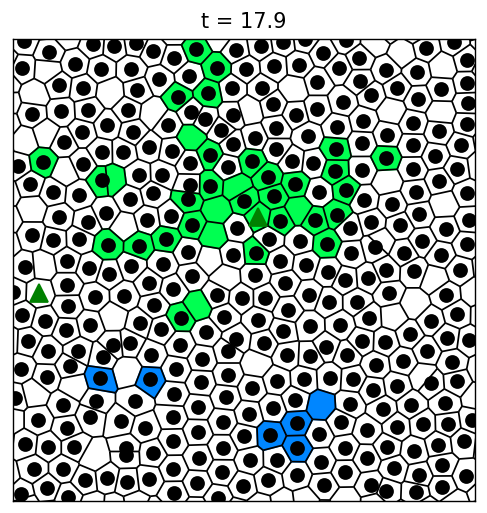

In [9]:
from importlib import reload
reload(tplt)

tiss = results['tiss']
positions = results['cellpos']
ancs = results['anc']
ancs = {**ancs[0], **ancs[1]}

cellid = results['cellid']
ncells = results['ncells']

track = [2682, 1789, 2319, 2621]

animation = tplt.clone_movies(positions, ancs, cellid, ncells = ncells, track = track, 
                         nsteps = 460, savename = 'sim_exp.mp4', fps = 10, 
                         saveskip = 10, diebytime = analysis.die_by_time(tiss, results, skip = 10, showfor = 100), 
                         delambytime = analysis.delam_by_time(tiss, results, skip = 10, showfor = 100), L = 20,
                         tscale = 200, tshift = -5, skip = 1); 